In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.stats import linregress


# Description
This notebook generates two files: bathy_grid.txt and bathy.txt. It does so by fitting a straight line through the bathymetric point measurements available, and projecting the bathymetric point measurements and the beach measurements onto that line. The intersection of the fitted line with the baseline for the bluff edge measurements is used as the origin of this new axis.

First load in the datasets containing bluff edge and shoreline data

In [3]:
# Read the bluff edge baseline into a GeoDataFrame (as a reference for the coastal retreat)
gdf_sl_bl = gpd.read_file('raw_datasets/gibbs/BarterIsland_ShorelineBaseline.zip').to_crs(epsg=26907)

then load in beach profile data

In [4]:
# csv file containing transects with bathymetric data for Barter island (measured in 2010-2011)
df = pd.read_csv("raw_datasets/erikson/Beachprofiledat/BTI_20102011BeachProfiles_Data.csv")

# use only central barter island
df = df[df.Site=="Central Barter Island"]

# convert to geodataframe
gdf_beach_profiles = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

finally, load in bathymetric data

In [5]:
# csv file containing bathymetric data (i.e., depth relative to MSL and absolute water depth at time of measurement) obtained trough different systems (measured between 2010 and 2011)
df_bath = pd.read_csv("raw_datasets/erikson/Single_beambath/BTI_20102011Bathymetry_Data.csv")


# Let us use only the relevant values on the northern shore of central barter island
mask = (df_bath.SYSTEM=='Humminbird') * (df_bath["Longitude"] > -143.75) * (df_bath["Longitude"] < -143.6) * (df_bath["Latitude"] > 70.12)
df_bath = df_bath[mask]

gdf_bath = gpd.GeoDataFrame(df_bath, geometry=gpd.points_from_xy(df_bath.Longitude.values, df_bath.Latitude.values, crs=4326))

Only look at bathymetric data from a single transect

In [6]:
mask = (gdf_bath.Longitude > -143.6568) * (gdf_bath.Longitude < -143.656) * (gdf_bath.Latitude < 70.142) * (gdf_bath.Latitude > 70.13)
gdf_bath_masked = gdf_bath[mask].dropna()

display(gdf_bath_masked)

,UTC_Date,UTC_Time,Longitude,Latitude,Depth_MSL,TRUDEPTH_M,SYSTEM,geometry
42609,07/10/2011,22:29:11,-143.656742,70.134173,1.67,1.69,Humminbird,POINT (-143.65674 70.13417)
42610,07/10/2011,22:29:12,-143.656661,70.134172,1.69,1.71,Humminbird,POINT (-143.65666 70.13417)
42611,07/10/2011,22:29:13,-143.656598,70.134172,1.72,1.74,Humminbird,POINT (-143.65660 70.13417)
42612,07/10/2011,22:29:14,-143.656517,70.134172,1.74,1.76,Humminbird,POINT (-143.65652 70.13417)
42613,07/10/2011,22:29:15,-143.656455,70.134172,1.76,1.78,Humminbird,POINT (-143.65645 70.13417)
...,...,...,...,...,...,...,...,...
42865,07/10/2011,22:34:06,-143.656652,70.140845,5.43,5.45,Humminbird,POINT (-143.65665 70.14084)
42866,07/10/2011,22:34:07,-143.656669,70.140861,5.45,5.47,Humminbird,POINT (-143.65667 70.14086)
42867,07/10/2011,22:34:08,-143.656697,70.140874,5.46,5.48,Humminbird,POINT (-143.65670 70.14087)
42868,07/10/2011,22:34:09,-143.656727,70.140889,5.48,5.50,Humminbird,POINT (-143.65673 70.14089)


lets look specifically at transect BTI-T5b, and create one dataset from it.

In [6]:
x_bath = gdf_bath_masked.to_crs(epsg=26907).geometry.x.values
y_bath = gdf_bath_masked.to_crs(epsg=26907).geometry.y.values
z_bath = gdf_bath_masked.to_crs(epsg=26907).Depth_MSL.values * -1

x_beach_T5b = gdf_beach_profiles[gdf_beach_profiles.TransectID=='BTI-T5b'].to_crs(epsg=26907).geometry.x.values
y_beach_T5b = gdf_beach_profiles[gdf_beach_profiles.TransectID=='BTI-T5b'].to_crs(epsg=26907).geometry.y.values
z_beach_T5b = gdf_beach_profiles[gdf_beach_profiles.TransectID=='BTI-T5b'].Ht_MSL

fit the line through bathymetry only, otherwise the orientation gets weird because bathymetry and shoreline data don't line up exactly.

In [7]:
x_all = np.concatenate([x_bath, x_beach_T5b])
y_all = np.concatenate([y_bath, y_beach_T5b])
z_all = np.concatenate([z_bath, z_beach_T5b])

# print(x_all)
# print(y_all)
# print(z_all)

In [8]:
slope, intercept, _, _, _ = linregress(x_bath, y_bath)

y_fitted = slope * x_bath + intercept

<Axes: >

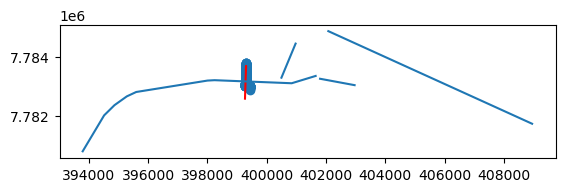

In [9]:
fig, ax = plt.subplots()

ax.scatter(x_all, y_all)

ax.plot(x_bath, y_fitted, color='red')
gdf_sl_bl.plot(ax=ax)

Determine the zero point, i.e. the intersection of the bluff edge baseline with the fitted line.

In [10]:
from shapely.geometry import LineString

In [11]:
geoseries = gpd.GeoSeries([
    LineString([(x_bath[0], y_fitted[0]), (x_bath[-1], y_fitted[-1])]),
    gdf_sl_bl.geometry.values[0]
])

intersection_point = geoseries[0].intersection(geoseries[1])

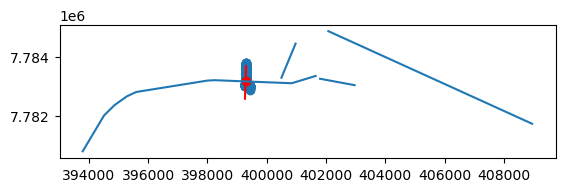

In [12]:
fig, ax = plt.subplots()

ax.scatter(x_all, y_all)

ax.plot(x_bath, y_fitted, color='red')
gdf_sl_bl.plot(ax=ax)
ax.scatter(intersection_point.x, intersection_point.y, color='red')

In [13]:

def project_point_onto_line(point, origin, line_direction):
    # Calculate the vector from the origin to the point
    vec_to_point = point - origin
    # Calculate the scalar projection of the vector onto the line direction
    scalar_projection = np.dot(vec_to_point, line_direction) / np.dot(line_direction, line_direction)
    # Calculate the projected point
    projected_point = origin + scalar_projection * line_direction
    return projected_point

In [14]:
projected_points = []

for x, y, z in zip(x_all, y_all, z_all):
    projected_point = project_point_onto_line(
        np.array((x, y)), 
        np.array((intersection_point.x, intersection_point.y)), 
        np.array([1, slope])
        )
    
    projected_points.append(projected_point)
    
projected_points = np.array(projected_points)

# print(projected_points)

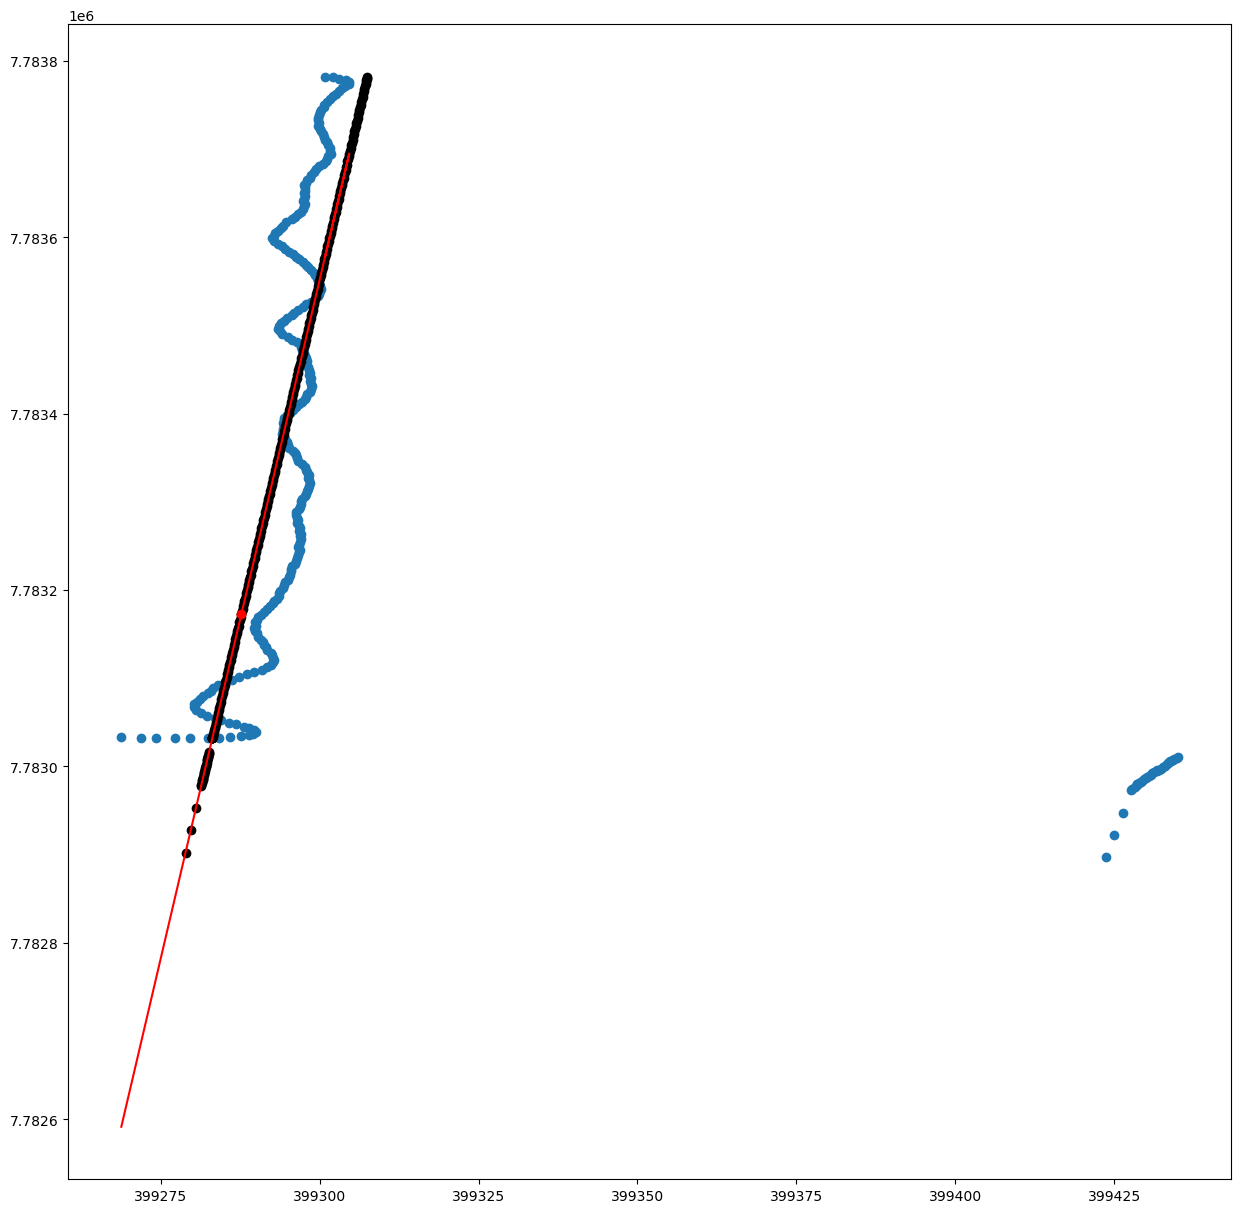

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(x_all, y_all)

ax.plot(x_bath, y_fitted, color='red')
# gdf_be_bl.plot(ax=ax)
ax.scatter(intersection_point.x, intersection_point.y, color='red')

ax.scatter(projected_points[:,0], projected_points[:,1], color='k')

ax.scatter(intersection_point.x, intersection_point.y, color='red')

We need to know the grid orientation with respect to the east, in degrees. That is just the inverse tangent of the slope of the fitted line.

In [16]:
orientation = np.arctan(slope) / (2*np.pi) * 360

print(f"orientation: {orientation:.2f} degrees")

orientation: 88.14 degrees


Now we can compute the distance to the origin for each point, and finally get the 1D coordinate system.

In [17]:
coords = []

for x_proj, y_proj, z in zip(projected_points[:,0], projected_points[:,1], z_all):
    distance = np.sqrt((x_proj - intersection_point.x)**2 + (y_proj - intersection_point.y)**2)
    
    if x_proj < intersection_point.x:
        distance *= -1
        
    coords.append(distance)
    
coords = np.array(coords)

This data is sorted

In [18]:
sort_indices = np.argsort(coords)
sorted_coords = coords[sort_indices]
sorted_z_all = z_all[sort_indices]

In [19]:
print(sorted_coords)

[-2.70490276e+02 -2.45398170e+02 -2.20308999e+02 -1.95217731e+02
 -1.93322627e+02 -1.91206987e+02 -1.89203292e+02 -1.88421771e+02
 -1.87975667e+02 -1.86863761e+02 -1.85638652e+02 -1.84301598e+02
 -1.82632481e+02 -1.81295846e+02 -1.79959211e+02 -1.78846047e+02
 -1.77399983e+02 -1.75950982e+02 -1.74727551e+02 -1.73281486e+02
 -1.72389278e+02 -1.71946109e+02 -1.70944891e+02 -1.68940357e+02
 -1.67158037e+02 -1.65041977e+02 -1.64151026e+02 -1.63260495e+02
 -1.62146492e+02 -1.61478594e+02 -1.60589740e+02 -1.59141159e+02
 -1.57918566e+02 -1.56693037e+02 -1.40716392e+02 -1.40574491e+02
 -1.40548332e+02 -1.40514153e+02 -1.40487566e+02 -1.40400797e+02
 -1.40341854e+02 -1.39751887e+02 -1.38653920e+02 -1.37218422e+02
 -1.35663805e+02 -1.33660554e+02 -1.31648446e+02 -1.29519329e+02
 -1.27501316e+02 -1.25032559e+02 -1.23012858e+02 -1.20320626e+02
 -1.17854820e+02 -1.15162586e+02 -1.11804570e+02 -1.08672981e+02
 -1.05991293e+02 -1.02532720e+02 -9.97475228e+01 -9.64051169e+01
 -9.29511848e+01 -8.95010

And reversed, with the miminum x-coord moved to x=0

In [20]:
sorted_coords_reversed = sorted_coords[::-1] * -1 + np.max(sorted_coords)
sorted_z_all_reversed = sorted_z_all[::-1]


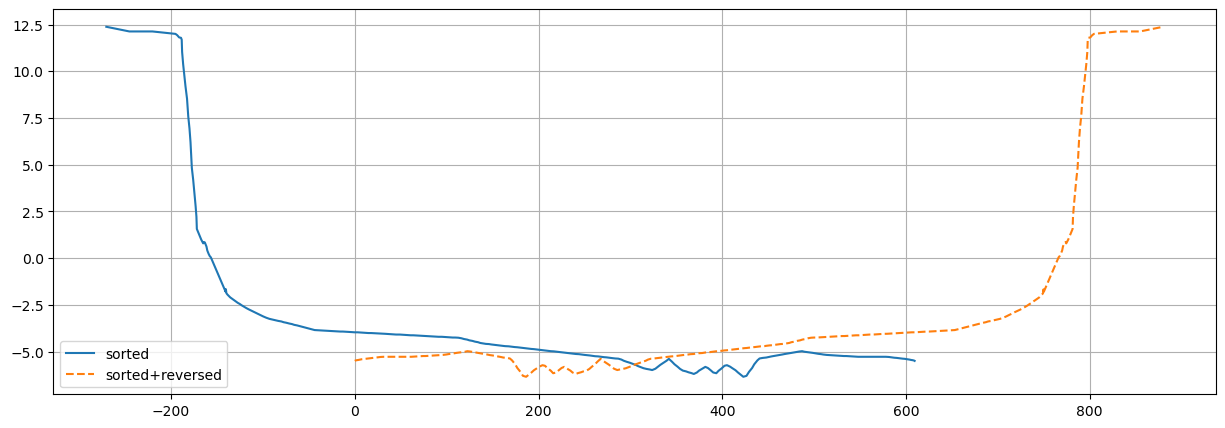

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sorted_coords, sorted_z_all, label='sorted')
ax.plot(sorted_coords_reversed, sorted_z_all_reversed, '--', label='sorted+reversed')

ax.legend()
ax.grid()
# ax.scatter(sorted_coords, sorted_z_all, color='red')

And finally, this data is saved to be used in the model.

In [22]:
save_dir = os.path.join(os.getcwd(), "initial_conditions/")

np.savetxt(os.path.join(save_dir, "x_data.grd"), sorted_coords_reversed)
np.savetxt(os.path.join(save_dir, "bed_data.dep"), sorted_z_all_reversed)
np.savetxt(os.path.join(save_dir, "orientation_data.txt"), np.ones(1)*orientation)

Also save a copy in the transects folder

In [23]:
save_dir = os.path.join(os.getcwd(), "transects/")

np.savetxt(os.path.join(save_dir, "x_data.grd"), sorted_coords_reversed)
np.savetxt(os.path.join(save_dir, "bed_data.dep"), sorted_z_all_reversed)
np.savetxt(os.path.join(save_dir, "orientation_data.txt"), np.ones(1)*orientation)